In [1]:
from pathlib import Path
from typing import Sequence, Union

import lightning
import matplotlib.pyplot as plt
import torch
from geodesic_cv.parse import create_contact_features, load_xtc
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from mlcolvar.cvs import DeepTDA, RegressionCV
from mlcolvar.data import DictDataset, DictModule
from mlcolvar.utils.plot import plot_metrics
from mlcolvar.utils.trainer import MetricsCallback

### Settings

In [2]:
# Trajectory extraction
stride = 10  # every 10 ps -> 5k frames

# Model and training settings
train_valid_split = [0.8, 0.2]
num_layers = [45, 24, 12, 1]
TDA_params = {"target_centers": [-7.0, 7.0], "target_sigmas": [0.2, 0.2]}
TDA_geo_params = {"target_centers": [-7.0, 0.0, 7.0], "target_sigmas": [0.2, 1.5, 0.2]}
max_epochs = 2000
early_stopping_patience = 50
model_save_path = Path("simulations/enhanced/plumed_files")

In [3]:
plt.style.use("default")


def plot_training_result(
    model: Union[RegressionCV, DeepTDA],
    features: Sequence[torch.Tensor],
    metrics: MetricsCallback,
):
    fig, ax = plt.subplots(1, 2, figsize=(8, 4), layout="constrained")
    plot_metrics(
        metrics.metrics, ax=ax[0], keys=["train_loss_epoch", "valid_loss"], yscale="log"
    )
    for i, feat in enumerate(features):
        with torch.no_grad():
            pred = model(feat).squeeze().cpu().numpy()
        ax[1].hist(pred, bins=50, label=f"state {i} (std: {pred.std():.2f})")
    ax[1].legend()
    ax[1].set_xlabel("CV")
    fig.show()

### Loading features and labels

In [4]:
xtc_uf = "simulations/unbiased/unfolded/trajout.xtc"
xtc_f = "simulations/unbiased/folded/trajout.xtc"
xtc_interp = "simulations/interpolation/trajout.xtc"
interp_t = torch.load("simulations/interpolation/interp_t.pt")

feat_uf = create_contact_features(load_xtc(xtc_uf)[::stride])
feat_f = create_contact_features(load_xtc(xtc_f)[::stride])
feat_interp = create_contact_features(load_xtc(xtc_interp))

### TDA

/home/gridsan/jnam/.conda/envs/geodesic-cv/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/gridsan/jnam/.conda/envs/geodesic-cv/lib/pytho ...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/gridsan/jnam/.conda/envs/geodesic-cv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[e

/home/gridsan/jnam/.conda/envs/geodesic-cv/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 534: 100%|██████████| 1/1 [00:00<00:00, 32.63it/s, v_num=0] 


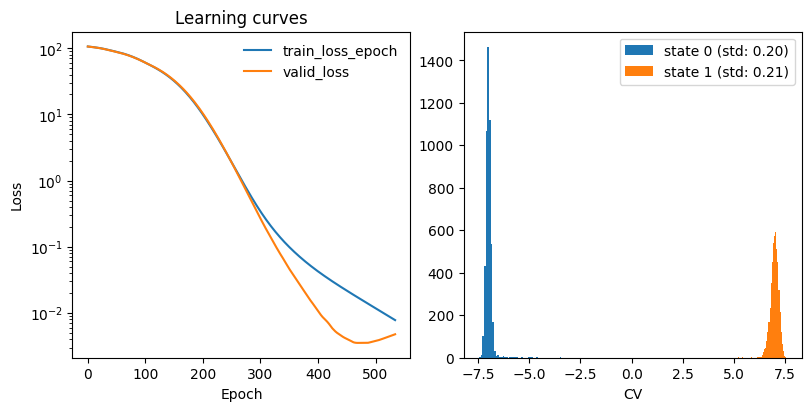

In [5]:
# Construct data
feat_all = torch.cat([feat_uf, feat_f], dim=0)
labels = torch.cat([torch.zeros(feat_uf.size(0)), torch.ones(feat_f.size(0))])
dataset = DictDataset({"data": feat_all, "labels": labels})
datamodule = DictModule(dataset, lengths=train_valid_split)

# Model
model = DeepTDA(
    n_states=2, n_cvs=1, layers=num_layers, **TDA_params, options={"norm_in": False}
)

# Define trainer and fit
metrics = MetricsCallback()
early_stop = EarlyStopping(monitor="valid_loss", patience=early_stopping_patience)
trainer = lightning.Trainer(
    callbacks=[metrics, early_stop],
    max_epochs=max_epochs,
    logger=None,
    enable_checkpointing=False,
)
trainer.fit(model, datamodule)

# Plot results
plot_training_result(model, [feat_uf, feat_f], metrics)

# Save model
model.to_torchscript(model_save_path / "TDA.pt", method="trace")

### TSE filtering
Skip this part to train the model without TSE filtering (`*_nofilter.pt`)

In [6]:
def get_TSE_mask_from_TDA(
    feat_interp: torch.Tensor,
    TDA_model_path: Path = Path("simulations/enhanced/plumed_files/TDA.pt"),
    TSE_range: tuple = (-5.0, 5.0),
):
    model = torch.jit.load(TDA_model_path)
    with torch.no_grad():
        cv_TDA = model(feat_interp)
    TSE_mask = (cv_TDA > TSE_range[0]) & (cv_TDA < TSE_range[1])
    return TSE_mask.squeeze()


# Filter the training data
TSE_mask = get_TSE_mask_from_TDA(feat_interp)
interp_t = interp_t[TSE_mask]
feat_interp = feat_interp[TSE_mask]

### TDA<sub>geo</sub>

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type        | Params | In sizes | Out sizes
---------------------------------------------------------------
0 | loss_fn | TDALoss     | 0      | ?        | ?        
1 | nn      | FeedForward | 1.4 K  | [45]     | [1]      
---------------------------------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.006     Total estimated model params size (MB)


Epoch 1903: 100%|██████████| 1/1 [00:00<00:00, 30.70it/s, v_num=1]          


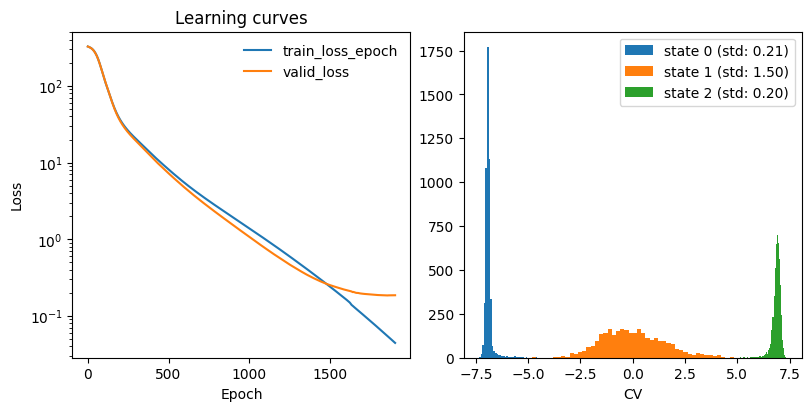

In [7]:
# Construct data
feat_all = torch.cat([feat_uf, feat_interp, feat_f], dim=0)
labels = [
    torch.full((feat_uf.size(0),), 0.0),
    torch.full((feat_interp.size(0),), 1.0),
    torch.full((feat_f.size(0),), 2.0),
]
labels = torch.cat(labels)
dataset = DictDataset({"data": feat_all, "labels": labels})
datamodule = DictModule(dataset, lengths=train_valid_split)

# Model
model = DeepTDA(
    n_states=3, n_cvs=1, layers=num_layers, **TDA_geo_params, options={"norm_in": False}
)

# Define trainer and fit
metrics = MetricsCallback()
early_stop = EarlyStopping(monitor="valid_loss", patience=early_stopping_patience)
trainer = lightning.Trainer(
    callbacks=[metrics, early_stop],
    max_epochs=max_epochs,
    logger=None,
    enable_checkpointing=False,
)
trainer.fit(model, datamodule)

# Plot results
plot_training_result(model, [feat_uf, feat_interp, feat_f], metrics)

# Save model
model.to_torchscript(model_save_path / "TDA_geo_filter.pt", method="trace")

### Reg<sub>geo</sub>

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type        | Params | In sizes | Out sizes
---------------------------------------------------------------
0 | loss_fn | MSELoss     | 0      | ?        | ?        
1 | nn      | FeedForward | 1.4 K  | [45]     | [1]      
---------------------------------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.006     Total estimated model params size (MB)


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 32.81it/s, v_num=2]          

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 25.69it/s, v_num=2]


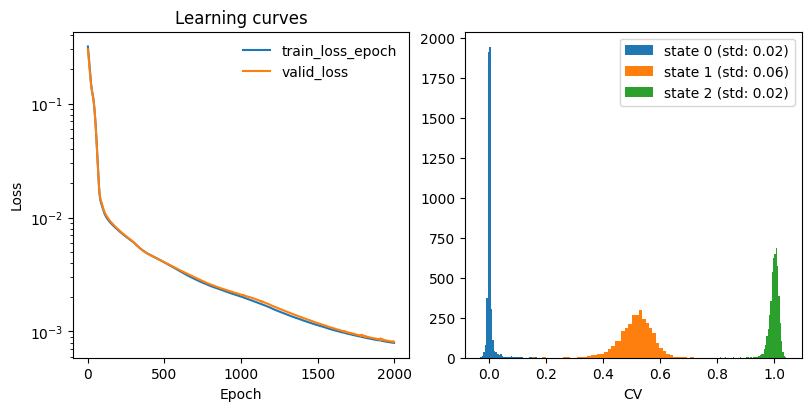

In [8]:
# Construct data
labels = [
    torch.full((feat_uf.size(0),), 0.0),
    interp_t,
    torch.full((feat_f.size(0),), 1.0),
]
labels = torch.cat(labels)
dataset = DictDataset({"data": feat_all, "target": labels})
datamodule = DictModule(dataset, lengths=train_valid_split)

# Model
model = RegressionCV(layers=num_layers, options={"norm_in": False})

# Define trainer and fit
metrics = MetricsCallback()
early_stop = EarlyStopping(monitor="valid_loss", patience=early_stopping_patience)
trainer = lightning.Trainer(
    callbacks=[metrics, early_stop],
    max_epochs=max_epochs,
    logger=None,
    enable_checkpointing=False,
)
trainer.fit(model, datamodule)

# Plot results
plot_training_result(model, [feat_uf, feat_interp, feat_f], metrics)

# Save model
model.to_torchscript(model_save_path / "Reg_geo_filter.pt", method="trace")